In [1]:
import os
import pandas as pd
from glob import glob
from sklearn.model_selection import StratifiedKFold

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
dataset_root = "melanoma_cancer_dataset/train"

image_paths = []
labels = []

class_names = sorted(os.listdir(dataset_root))  # keep consistent class order

for label in class_names:
    class_dir = os.path.join(dataset_root, label)
    if os.path.isdir(class_dir):
        img_files = glob(os.path.join(class_dir, "*.jpg")) + \
                    glob(os.path.join(class_dir, "*.png")) + \
                    glob(os.path.join(class_dir, "*.jpeg"))
        image_paths.extend(img_files)
        labels.extend([label] * len(img_files))

df = pd.DataFrame({"image": image_paths, "label": labels})
print(df.head())
print("Total images:", len(df))
print("Classes:", class_names)


                                               image   label
0  melanoma_cancer_dataset/train/benign/melanoma_...  benign
1  melanoma_cancer_dataset/train/benign/melanoma_...  benign
2  melanoma_cancer_dataset/train/benign/melanoma_...  benign
3  melanoma_cancer_dataset/train/benign/melanoma_...  benign
4  melanoma_cancer_dataset/train/benign/melanoma_...  benign
Total images: 9605
Classes: ['benign', 'malignant']


In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_idx"] = le.fit_transform(df["label"])

num_classes = len(le.classes_)
print("Class to Index Mapping:", dict(zip(le.classes_, range(num_classes))))


Class to Index Mapping: {'benign': 0, 'malignant': 1}


In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df["fold"] = -1
for fold, (_, val_idx) in enumerate(skf.split(df["image"], df["label_idx"])):
    df.loc[val_idx, "fold"] = fold

df["fold"].value_counts()


fold
1    1921
2    1921
0    1921
3    1921
4    1921
Name: count, dtype: int64

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [6]:
class SkinCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image"]
        label = self.df.loc[idx, "label_idx"]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, label


In [7]:
def get_dataloaders(fold, batch_size=64):
    train_df = df[df.fold != fold]
    val_df = df[df.fold == fold]

    train_dataset = SkinCancerDataset(train_df, transform=train_transform)
    val_dataset = SkinCancerDataset(val_df, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2)
    return train_loader, val_loader


In [8]:
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def create_model(num_classes):
    weights = EfficientNet_B0_Weights.DEFAULT
    model = efficientnet_b0(weights=weights)

    # Freeze only early layers (blocks 0–4)
    for idx, block in enumerate(model.features):
        if idx < 5:
            for param in block.parameters():
                param.requires_grad = False
        else:
            for param in block.parameters():
                param.requires_grad = True

    # Replace classifier for 9 classes
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model.to(device)


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_idx']),
    y=df['label_idx']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion


CrossEntropyLoss()

In [10]:
def get_optimizer(model, lr=1e-3):
    # Only include parameters that require gradients
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(trainable_params, lr=lr, weight_decay=1e-5)
    return optimizer


In [11]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    preds, targets = [], []
    
    for imgs, labels in tqdm(loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds.extend(outputs.argmax(dim=1).cpu().numpy())
        targets.extend(labels.cpu().numpy())

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='macro')
    return total_loss/len(loader), acc, f1


def validate_one_epoch(model, loader):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='macro')
    return total_loss/len(loader), acc, f1


In [12]:
EPOCHS = 10  # can increase later if time allows
BATCH_SIZE = 32

fold_performance = []

for fold in range(5):
    print(f"\n===== FOLD {fold+1} / 5 =====")
    
    train_loader, val_loader = get_dataloaders(fold, batch_size=BATCH_SIZE)
    model = create_model(num_classes)
    optimizer = get_optimizer(model)

    best_f1 = 0
    best_model_path = f"best_bin_model_fold{fold}.pt"

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc, val_f1 = validate_one_epoch(model, val_loader)

        print(f"Train Loss: {train_loss:.4f} | ACC: {train_acc:.4f} | F1: {train_f1:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | ACC: {val_acc:.4f} | F1: {val_f1:.4f}")

        # Save best fold model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), best_model_path)
            print(">>> Saved best model so far!")

    fold_performance.append({
        "fold": fold,
        "best_f1": best_f1
    })

print("\n=== Final Fold Results ===")
print(pd.DataFrame(fold_performance))



===== FOLD 1 / 5 =====

Epoch 1/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.77it/s]


Train Loss: 0.3043 | ACC: 0.8722 | F1: 0.8718
Val   Loss: 0.3736 | ACC: 0.8839 | F1: 0.8814
>>> Saved best model so far!

Epoch 2/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.77it/s]


Train Loss: 0.2439 | ACC: 0.9047 | F1: 0.9043
Val   Loss: 0.2433 | ACC: 0.9006 | F1: 0.8989
>>> Saved best model so far!

Epoch 3/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.99it/s]


Train Loss: 0.2266 | ACC: 0.9115 | F1: 0.9111
Val   Loss: 0.2080 | ACC: 0.9105 | F1: 0.9097
>>> Saved best model so far!

Epoch 4/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.71it/s]


Train Loss: 0.2118 | ACC: 0.9188 | F1: 0.9185
Val   Loss: 0.2074 | ACC: 0.9172 | F1: 0.9168
>>> Saved best model so far!

Epoch 5/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.18it/s]


Train Loss: 0.2059 | ACC: 0.9171 | F1: 0.9168
Val   Loss: 0.1890 | ACC: 0.9193 | F1: 0.9186
>>> Saved best model so far!

Epoch 6/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.10it/s]


Train Loss: 0.1938 | ACC: 0.9200 | F1: 0.9197
Val   Loss: 0.2031 | ACC: 0.9172 | F1: 0.9164

Epoch 7/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.26it/s]


Train Loss: 0.1885 | ACC: 0.9239 | F1: 0.9236
Val   Loss: 0.2045 | ACC: 0.9162 | F1: 0.9151

Epoch 8/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.12it/s]


Train Loss: 0.1779 | ACC: 0.9323 | F1: 0.9320
Val   Loss: 0.1753 | ACC: 0.9250 | F1: 0.9244
>>> Saved best model so far!

Epoch 9/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.06it/s]


Train Loss: 0.1805 | ACC: 0.9325 | F1: 0.9322
Val   Loss: 0.2213 | ACC: 0.9131 | F1: 0.9118

Epoch 10/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.86it/s]


Train Loss: 0.1826 | ACC: 0.9283 | F1: 0.9280
Val   Loss: 0.1974 | ACC: 0.9188 | F1: 0.9181

===== FOLD 2 / 5 =====

Epoch 1/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.29it/s]


Train Loss: 0.3129 | ACC: 0.8721 | F1: 0.8716
Val   Loss: 0.2296 | ACC: 0.9131 | F1: 0.9127
>>> Saved best model so far!

Epoch 2/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.17it/s]


Train Loss: 0.2516 | ACC: 0.8968 | F1: 0.8962
Val   Loss: 0.1983 | ACC: 0.9250 | F1: 0.9246
>>> Saved best model so far!

Epoch 3/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.05it/s]


Train Loss: 0.2230 | ACC: 0.9094 | F1: 0.9091
Val   Loss: 0.2516 | ACC: 0.9079 | F1: 0.9065

Epoch 4/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.93it/s]


Train Loss: 0.2282 | ACC: 0.9045 | F1: 0.9041
Val   Loss: 0.1888 | ACC: 0.9266 | F1: 0.9260
>>> Saved best model so far!

Epoch 5/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.91it/s]


Train Loss: 0.2050 | ACC: 0.9174 | F1: 0.9171
Val   Loss: 0.1992 | ACC: 0.9276 | F1: 0.9271
>>> Saved best model so far!

Epoch 6/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.76it/s]


Train Loss: 0.2012 | ACC: 0.9227 | F1: 0.9224
Val   Loss: 0.2062 | ACC: 0.9417 | F1: 0.9415
>>> Saved best model so far!

Epoch 7/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.18it/s]


Train Loss: 0.1913 | ACC: 0.9233 | F1: 0.9231
Val   Loss: 0.2185 | ACC: 0.9334 | F1: 0.9330

Epoch 8/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.73it/s]


Train Loss: 0.1852 | ACC: 0.9243 | F1: 0.9240
Val   Loss: 0.2212 | ACC: 0.9381 | F1: 0.9376

Epoch 9/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.07it/s]


Train Loss: 0.1771 | ACC: 0.9258 | F1: 0.9256
Val   Loss: 0.1792 | ACC: 0.9469 | F1: 0.9467
>>> Saved best model so far!

Epoch 10/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.86it/s]


Train Loss: 0.1762 | ACC: 0.9295 | F1: 0.9292
Val   Loss: 0.1855 | ACC: 0.9433 | F1: 0.9431

===== FOLD 3 / 5 =====

Epoch 1/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.89it/s]


Train Loss: 0.3052 | ACC: 0.8738 | F1: 0.8732
Val   Loss: 0.2033 | ACC: 0.9172 | F1: 0.9166
>>> Saved best model so far!

Epoch 2/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.82it/s]


Train Loss: 0.2542 | ACC: 0.9028 | F1: 0.9024
Val   Loss: 0.2435 | ACC: 0.9073 | F1: 0.9063

Epoch 3/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.31it/s]


Train Loss: 0.2369 | ACC: 0.9062 | F1: 0.9058
Val   Loss: 0.1893 | ACC: 0.9245 | F1: 0.9238
>>> Saved best model so far!

Epoch 4/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.11it/s]


Train Loss: 0.2208 | ACC: 0.9136 | F1: 0.9133
Val   Loss: 0.1570 | ACC: 0.9313 | F1: 0.9309
>>> Saved best model so far!

Epoch 5/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.97it/s]


Train Loss: 0.2249 | ACC: 0.9171 | F1: 0.9168
Val   Loss: 0.1869 | ACC: 0.9219 | F1: 0.9216

Epoch 6/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.90it/s]


Train Loss: 0.2146 | ACC: 0.9128 | F1: 0.9125
Val   Loss: 0.1577 | ACC: 0.9292 | F1: 0.9287

Epoch 7/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.92it/s]


Train Loss: 0.1958 | ACC: 0.9243 | F1: 0.9239
Val   Loss: 0.1933 | ACC: 0.9188 | F1: 0.9188

Epoch 8/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.96it/s]


Train Loss: 0.1942 | ACC: 0.9220 | F1: 0.9218
Val   Loss: 0.1764 | ACC: 0.9386 | F1: 0.9381
>>> Saved best model so far!

Epoch 9/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.10it/s]


Train Loss: 0.1845 | ACC: 0.9257 | F1: 0.9254
Val   Loss: 0.1494 | ACC: 0.9391 | F1: 0.9388
>>> Saved best model so far!

Epoch 10/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.97it/s]


Train Loss: 0.1799 | ACC: 0.9300 | F1: 0.9297
Val   Loss: 0.1590 | ACC: 0.9334 | F1: 0.9330

===== FOLD 4 / 5 =====

Epoch 1/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.69it/s]


Train Loss: 0.3046 | ACC: 0.8761 | F1: 0.8757
Val   Loss: 0.2378 | ACC: 0.8974 | F1: 0.8974
>>> Saved best model so far!

Epoch 2/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.08it/s]


Train Loss: 0.2456 | ACC: 0.9045 | F1: 0.9041
Val   Loss: 0.2294 | ACC: 0.9141 | F1: 0.9130
>>> Saved best model so far!

Epoch 3/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.81it/s]


Train Loss: 0.2372 | ACC: 0.9054 | F1: 0.9050
Val   Loss: 0.1682 | ACC: 0.9334 | F1: 0.9329
>>> Saved best model so far!

Epoch 4/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.69it/s]


Train Loss: 0.2094 | ACC: 0.9155 | F1: 0.9152
Val   Loss: 0.1847 | ACC: 0.9271 | F1: 0.9264

Epoch 5/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.95it/s]


Train Loss: 0.2003 | ACC: 0.9184 | F1: 0.9181
Val   Loss: 0.1942 | ACC: 0.9172 | F1: 0.9165

Epoch 6/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.15it/s]


Train Loss: 0.2043 | ACC: 0.9226 | F1: 0.9223
Val   Loss: 0.1615 | ACC: 0.9360 | F1: 0.9358
>>> Saved best model so far!

Epoch 7/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.82it/s]


Train Loss: 0.1925 | ACC: 0.9227 | F1: 0.9224
Val   Loss: 0.1651 | ACC: 0.9427 | F1: 0.9424
>>> Saved best model so far!

Epoch 8/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 14.48it/s]


Train Loss: 0.1808 | ACC: 0.9276 | F1: 0.9274
Val   Loss: 0.1648 | ACC: 0.9323 | F1: 0.9321

Epoch 9/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.99it/s]


Train Loss: 0.1918 | ACC: 0.9310 | F1: 0.9308
Val   Loss: 0.1581 | ACC: 0.9365 | F1: 0.9362

Epoch 10/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.19it/s]


Train Loss: 0.1898 | ACC: 0.9297 | F1: 0.9295
Val   Loss: 0.1771 | ACC: 0.9302 | F1: 0.9295

===== FOLD 5 / 5 =====

Epoch 1/10


Validating: 100%|███████████████████████████████| 61/61 [00:04<00:00, 13.30it/s]


Train Loss: 0.3105 | ACC: 0.8747 | F1: 0.8743
Val   Loss: 0.1911 | ACC: 0.9224 | F1: 0.9217
>>> Saved best model so far!

Epoch 2/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.19it/s]


Train Loss: 0.2526 | ACC: 0.8954 | F1: 0.8950
Val   Loss: 0.2635 | ACC: 0.9011 | F1: 0.8993

Epoch 3/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.11it/s]


Train Loss: 0.2403 | ACC: 0.9017 | F1: 0.9014
Val   Loss: 0.1753 | ACC: 0.9302 | F1: 0.9296
>>> Saved best model so far!

Epoch 4/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.31it/s]


Train Loss: 0.2119 | ACC: 0.9172 | F1: 0.9169
Val   Loss: 0.1978 | ACC: 0.9297 | F1: 0.9290

Epoch 5/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.31it/s]


Train Loss: 0.2000 | ACC: 0.9196 | F1: 0.9193
Val   Loss: 0.1879 | ACC: 0.9365 | F1: 0.9362
>>> Saved best model so far!

Epoch 6/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.35it/s]


Train Loss: 0.2043 | ACC: 0.9197 | F1: 0.9194
Val   Loss: 0.1719 | ACC: 0.9302 | F1: 0.9296

Epoch 7/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.36it/s]


Train Loss: 0.2027 | ACC: 0.9200 | F1: 0.9197
Val   Loss: 0.1514 | ACC: 0.9407 | F1: 0.9404
>>> Saved best model so far!

Epoch 8/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.23it/s]


Train Loss: 0.1843 | ACC: 0.9260 | F1: 0.9257
Val   Loss: 0.1665 | ACC: 0.9334 | F1: 0.9330

Epoch 9/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.44it/s]


Train Loss: 0.1822 | ACC: 0.9265 | F1: 0.9262
Val   Loss: 0.1847 | ACC: 0.9235 | F1: 0.9227

Epoch 10/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.46it/s]

Train Loss: 0.1817 | ACC: 0.9305 | F1: 0.9303
Val   Loss: 0.1592 | ACC: 0.9412 | F1: 0.9409
>>> Saved best model so far!

=== Final Fold Results ===
   fold   best_f1
0     0  0.924353
1     1  0.946698
2     2  0.938769
3     3  0.942410
4     4  0.940853


In [15]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Paths
BEST_MODEL_PATH = "best_bin_model_fold1.pt"  # <- Update fold if needed
TEST_DIR = "melanoma_cancer_dataset/test"

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Same transforms used in validation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load test dataset
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load model (EfficientNet B0)
from torchvision.models import efficientnet_b0
model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(test_dataset.classes))
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.to(device)
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Metrics
print("\n=== TEST SET RESULTS ===")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=4))

cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=test_dataset.classes, columns=test_dataset.classes)

print("\n=== CONFUSION MATRIX ===")
print(cm_df)


/home/rishabhjp/anaconda3/envs/miniproject/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabhjp/anaconda3/envs/miniproject/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_15880/2323411745.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for


=== TEST SET RESULTS ===
              precision    recall  f1-score   support

      benign     0.8864    0.9520    0.9180       500
   malignant     0.9482    0.8780    0.9117       500

    accuracy                         0.9150      1000
   macro avg     0.9173    0.9150    0.9149      1000
weighted avg     0.9173    0.9150    0.9149      1000


=== CONFUSION MATRIX ===
           benign  malignant
benign        476         24
malignant      61        439


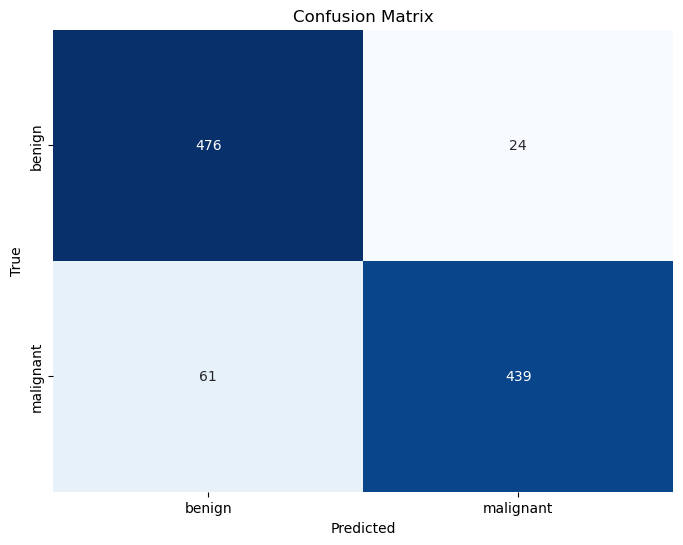

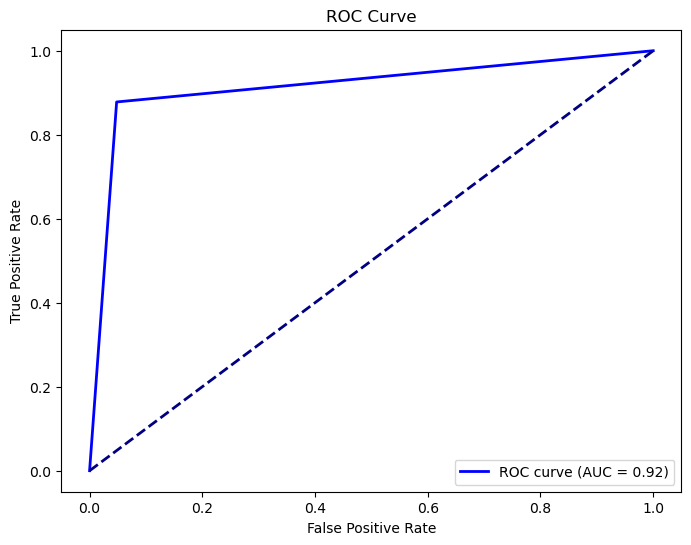

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Prepare labels for ROC AUC
y_true_bin = label_binarize(all_labels, classes=[0, 1])  # Assuming 'benign' = 0, 'malignant' = 1
y_pred_bin = label_binarize(all_preds, classes=[0, 1])

# ROC curve plotting
fpr, tpr, _ = roc_curve(y_true_bin, y_pred_bin)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
